In [1]:
import csv
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
from datetime import datetime
import numpy as np
import os
import yfinance as yf

#%% Reading all the csv files from Interactive brokers
cwd = os.getcwd()
cwd = os.path.dirname(cwd)
file_names = [i for i in os.listdir(cwd) if i[-4:] == ".csv"]
file_names = [i for i in os.listdir(f'{cwd}\\dashboard\\InputFiles\\IB') if i[-4:] == ".csv"]
print(file_names)

def read_csv_with_identifier(filepath, identifier):
    relevant_rows = []
    header = None
    header_found = False

    # Open the file and read it using the csv reader
    with open(filepath, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Check if the first column matches the identifier
            if row[0] == identifier:
                # If header is not found yet, treat this row as the header
                if not header_found:
                    header = row
                    header_found = True
                relevant_rows.append(row)

    if header_found:
        df = pd.DataFrame(relevant_rows[1:], columns=header)
    else:
        df = pd.DataFrame(relevant_rows)
    df = df[df["Header"] == "Data"].copy()
    return df


def get_exchange_rates(base_currency, target_currency='CHF', start_date='2021-01-01'):
    # Fetch historical data for the currency pair
    currency_pair = f'{base_currency}{target_currency}=X'
    ticker = yf.Ticker(currency_pair)
    exchange_df = ticker.history(start=start_date, interval='1d')
    exchange_df = exchange_df[['Close']]  # Use 'Close' as the exchange rate
    exchange_df.rename(columns={'Close': 'Rate'}, inplace=True)
    exchange_df.index = exchange_df.index.date  # Convert index to date only
    exchange_df.index.name = 'Date'
    return exchange_df

def get_daily_OpenClose(symbols, start_date, exception_lst, df_symbol_currency):
    data_frames = []

    for symbol in symbols:
        if symbol not in exception_lst:
            ticker = yf.Ticker(symbol)
            try:
                df = ticker.history(start=start_date, interval="1d")
                df.index = df.index.date  # Convert index to date only
                df['Symbol'] = symbol
                # Assume the ticker's currency is the same as its stock market currency
                #market_currency = ticker.info.get('currency', 'USD')
                market_currency = df_symbol_currency[df_symbol_currency["Symbol"]==symbol]["Currency"].iloc[0]

                if market_currency != 'CHF':
                    # Get exchange rates from market currency to USD
                    exchange_df = get_exchange_rates(market_currency, 'CHF', start_date)
                    if not exchange_df.empty:
                        # Merge stock data with exchange rates
                        df = df.join(exchange_df, how='right')
                        
                        df.dropna(inplace=True)
                        df['Open'] = df['Open'] * df['Rate']
                        df['High'] = df['High'] * df['Rate']
                        df['Low'] = df['Low'] * df['Rate']
                        df['Close_CHF'] = df['Close'] * df['Rate']
                        df['Dividends_CHF'] = df['Dividends'] * df['Rate']
                        df['Currency'] = market_currency
                    else:
                        df['Currency'] = market_currency
                else:
                    df['Currency'] = 'CHF'

                data_frames.append(df)
            except Exception as e:
                print(f"Error fetching exchange rates for {e}")

    combined_df = pd.concat(data_frames)
    combined_df.reset_index(inplace=True)
    combined_df = combined_df[["Date","Dividends_CHF","Symbol","Close_CHF", "Stock Splits"]].copy()
    combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%Y-%m-%d')
    return combined_df

def get_daily_stock_data(symbols, start_date, exception_lst):
    data_frames = []

    for symbol in symbols:
        if symbol not in exception_lst:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, interval="1d")
            df['Symbol'] = symbol
            # Append the DataFrame to the list
            data_frames.append(df)

    data_frames = pd.concat(data_frames)
    # Reset the index
    #combined_df.reset_index(inplace=True)
    
    return data_frames

def final_df(stock_data, df_all):
    stock_data = stock_data.sort_values(by=['Symbol', 'Date'], ascending=[True, False])
    #stock_data['Cumsum_Splits'] = stock_data.groupby('Symbol')['Stock Splits'].cumsum()[::-1]
    stock_data['Cumsum_Splits'] = (
        stock_data['Stock Splits']
        .replace(0, 1) 
        .groupby(stock_data['Symbol']) 
        .cumprod()[::-1]  
    )
    stock_data['Cumsum_Splits'].replace(0,np.nan, inplace=True) #We need a value of 1 to multiply
    stock_data = stock_data.sort_values(by=['Symbol', 'Date'], ascending=[True, True])

    df_all = df_all[df_all["Asset Category"] != "Forex"].copy()
    df_stocks = df_all[df_all["Asset Category"] == "Stocks"].copy()

    df_stocks = df_stocks[['Date',"Symbol","Quantity"]].copy()
    df_stocks['Quantity'] = pd.to_numeric(df_stocks['Quantity'], errors='coerce')

    df_stock_value = pd.merge(stock_data, df_stocks, on = ["Date","Symbol"], how = 'outer')
    df_stock_value = df_stock_value.sort_values(by=['Symbol',"Date"])
    df_stock_value["Cumsum_Splits"].fillna(1,inplace=True)

    df_stock_value['Quantity_cum'] = df_stock_value['Cumsum_Splits'] * df_stock_value['Quantity']
    df_stock_value['Quantity_cum'].fillna(0, inplace=True)

    df_stock_value['Stock Quantity']  = df_stock_value.groupby('Symbol')['Quantity_cum'].cumsum()

    df_stock_value['Dividends_CHF_tot'] = df_stock_value['Dividends_CHF'] * df_stock_value["Stock Quantity"]
    df_stock_value['Dividends_tot']  = df_stock_value.groupby('Symbol')['Dividends_CHF_tot'].cumsum()

    import datetime
    df_stock_value["total_chf"] = df_stock_value["Stock Quantity"] * df_stock_value["Close_CHF"]
    df_stock_value['Date'] = pd.to_datetime(df_stock_value['Date'])
    filter_date = datetime.date(2024, 9, 20)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)

    print( df_stock_value[df_stock_value["Date"].dt.date == filter_date]["total_chf"].sum())
    print( df_stock_value[df_stock_value["Date"].dt.date == filter_date]["Dividends_tot"].sum())
    df_stock_value = df_stock_value[["Date", "Symbol", "Stock Quantity","Close_CHF" ,"Dividends_tot","total_chf"]].copy()

    print(df_stock_value[df_stock_value["Date"].dt.date == filter_date])

    return df_stock_value

def get_ticker_from_isin(isin):
    isin_to_ticker = {
        "US0378331005": "AAPL",  
        "US0231351067": "AMZN", 
        "US64110L1061": "NFLX",
        "US67066G1040" : "NVDA",
        "US86646P1030" : "SUMO",
        "US88160R1014" : "TSLA",
        "US44916T1079" : "HYRE",
        "US73739W1045": "POSH",
        "US02079K3059" : "GOOGL",
        "IE00B3RBWM25": "VWRL.AS",
        "US98980F1049" : "ZI",
        "US90184L1026" : "TWTR", 
        "US0567521085" : "BIDU",
        "US98983V1061" : "ZUO",
        "US82452J1097" : "FOUR",
        "US22788C1053" : "CRWD",
        "US00165C1045" : "AMC",
        "CH0590186661" : "SPISI",
        "IE00BGDPWW94" : "36B3",
        "IE00B4K48X80" : "IMAE", 
        "IE00B60SWY32" : "SCOE",
        "IE00BFNM3H51" : "SLMI",
        "IE00BYVTMS52" : "EQEU",
        "US5840211099" : "MDLA",
        "US01609W1027" : "BABA",
        "US30303M1027" : "META",
        "NO0010989247" : "NAST",
        "NO0010887516" : "TECO.OL",
        "US7710491033" : "RBLX",
        "US92918V1098" : "VRM",
        "US12468P1049" : "AI",
        "FR0000120271" : "TTE",
        "US79466L3024" : "CRM",
        "US5949181045" : "MSFT",
        "US0090661010" : "ABNB",
        "US68389X1054" : "ORCL",
        "US8334451098" : "SNOW",
        "US0900401060" : "BILI",
        "US00827B1061" : "AFRM",
        "IL0011582033" : "FVRR",
        "US52567D1072":"LMND",
        "NO0010989247" : "NAS.OL",
        "US12047B1052":"BMBL",
        "US7501021056" : "RXT",
        "DE000A0LR9G9" : "EXL.DE",
        "US70614W1009":"PTON",
        "LU1778762911" : "SPOT",
        "US08862E1091" : "BYND",
        "US76155X1000" : "RVMD",
        "US72352L1061" : "PINS",
        "IL0011684185" : "FROG",
        "CA09228F1036" : "BB"        
     }
    
    return isin_to_ticker.get(isin)

def add_tickers_to_dataframe(df):
    ticker_cache = {}
    
    unique_isins = df['ISIN'].unique()
    
    for isin in unique_isins:
        if isin not in ticker_cache:
            ticker_cache[isin] = get_ticker_from_isin(isin)
    
    # Map the tickers back to the DataFrame
    df['Symbol'] = df['ISIN'].map(ticker_cache)
    df = df[["Date","Symbol","Quantity", "Asset Category","Currency"]].copy()
    df.dropna(inplace=True)
    return df

def read_degiro():
    df_degiro = []
    file_names_degiro = [i for i in os.listdir(f'{cwd}\\dashboard\\InputFiles\\Degiro') if i[-4:] == ".csv"]

    for file_name in file_names_degiro:
        df = pd.read_csv(f'{cwd}\\dashboard\\InputFiles\\Degiro\\{file_name}')
        df_degiro.append(df)
    df_degiro = pd.concat(df_degiro)

    #Degiro reports stock split as a buy and a sell again which we should remove
    df_degiro['Datum'] = df_degiro['Datum'].astype(str)
    df_degiro['Produkt'] = df_degiro['Produkt'].astype(str)
    df_degiro = df_degiro.sort_values(by=['Datum', 'Produkt']).reset_index(drop=True)
    #df_degiro = df_degiro[df_degiro["ISIN"] =="US67066G1040"].copy().reset_index()
    to_drop = []
    for i in range(1, len(df_degiro)):
        # Check if 'Datum' and 'Produkt' are the same for consecutive rows
        if (df_degiro.loc[i, 'Datum'] == df_degiro.loc[i - 1, 'Datum']) and (df_degiro.loc[i, 'Produkt'] == df_degiro.loc[i - 1, 'Produkt']):
            # Check if 'Wert' has same absolute value but opposite signs
            if abs(df_degiro.loc[i, 'Wert']) == abs(df_degiro.loc[i - 1, 'Wert']) and df_degiro.loc[i, 'Wert'] != df_degiro.loc[i - 1, 'Wert']:
                to_drop.append(i)
                to_drop.append(i - 1)

    df_degiro = df_degiro.drop(to_drop).reset_index(drop=True)

    df_degiro = df_degiro[["Datum","ISIN","Anzahl","Unnamed: 8"]].copy()
    df_degiro = df_degiro.rename(columns={"Datum" : "Date","Anzahl": "Quantity", "Unnamed: 8" : "Currency"})
    df_degiro["Asset Category"] = "Stocks"
    df_degiro['Date'] = pd.to_datetime(df_degiro['Date'], format='%d-%m-%Y')
    df_degiro = add_tickers_to_dataframe(df_degiro)
    return df_degiro

def read_IB(file_names):
    df_all = []
    for file_name in file_names:
        df = read_csv_with_identifier(f'..\\dashboard\\InputFiles\\IB\\{file_name}', "Trades")
        df_all.append(df)
    df_all = pd.concat(df_all)

    df_all['Date/Time'] = pd.to_datetime(df_all['Date/Time'], format='%Y-%m-%d, %H:%M:%S')
    df_all['Date'] = df_all['Date/Time'].dt.date
    df_all = df_all[["Date","Symbol","Quantity", "Asset Category","Currency"]].copy()
    df_all['Quantity'] = pd.to_numeric(df_all['Quantity'], errors='coerce')

    new_row = [
            {'Date':'2024-09-11', 'Symbol': "SIRI", 'Quantity':67, 'Asset Category' :"Stocks", "Currency":"USD"}, 
            {'Date':'2021-11-01', 'Symbol': "IBKR", 'Quantity':13.8818, 'Asset Category' :"Stocks", "Currency":"USD"}, 
                ]
    df_all = pd.concat([df_all, pd.DataFrame(new_row)], axis=0, ignore_index=True)
    df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')
    return df_all

['2021.csv', '2022.csv', '2023.csv', '2024.csv', '2025.csv']


In [2]:
symbols = ["AAPL"]
exception_lst = ["CHF.USD","EUR.USD", "USD.CHF","USD.EUR", "EUR.CHF","USD.HKD", "NNND.F.SPO","$SOXX 19JUL24 223.33 P","VMW", "NNND.F.SPO", "SOXX 20JUN25 230 P",\
                 "SOXX 19JUL24 223.33 P","SOXX 20JUN25 230 P","SOXX 19JUL24 223.33 P","NNND.F.SPO","SOXX 19JUL24 223.33 P","SOXX 20JUN25 230 P", "MDLA","SLMI","HYRE",\
                "POSH", "EQEU", "SUMO", "IMAE","TWTR", "SPISI", "SCOE", "36B3"]
df_symbol_currency = ['USD']
symbol = 'AAPL'
ticker = yf.Ticker(symbol)
start_date = '2020-01-01'

df = ticker.history(start=start_date, interval="1d")
print(ticker)
df.index = df.index.date  # Convert index to date only
df['Symbol'] = symbol
# Assume the ticker's currency is the same as its stock market currency
#market_currency = ticker.info.get('currency', 'USD')
market_currency = df_symbol_currency[df_symbol_currency["Symbol"]==symbol]["Currency"].iloc[0]

if market_currency != 'CHF':
    # Get exchange rates from market currency to USD
    exchange_df = get_exchange_rates(market_currency, 'CHF', start_date)
    if not exchange_df.empty:
        # Merge stock data with exchange rates
        df = df.join(exchange_df, how='right')
        
        df.dropna(inplace=True)
        df['Open'] = df['Open'] * df['Rate']
        df['High'] = df['High'] * df['Rate']
        df['Low'] = df['Low'] * df['Rate']
        df['Close_CHF'] = df['Close'] * df['Rate']
        df['Dividends_CHF'] = df['Dividends'] * df['Rate']
        df['Currency'] = market_currency
    else:
        df['Currency'] = market_currency
else:
    df['Currency'] = 'CHF'




yfinance.Ticker object <AAPL>


TypeError: list indices must be integers or slices, not str

In [3]:
df_IB = read_IB(file_names)
df_degiro = read_degiro()

#Merge and get Stock data
df_all = pd.concat([df_IB,df_degiro])
df_all = df_all.groupby(['Date', 'Symbol',"Asset Category","Currency"], as_index=False)['Quantity'].sum()

df_all = df_all[df_all["Asset Category"] != "Forex"].copy()
df_all['Symbol'] = df_all['Symbol'].replace({"NNND":"NNND.F","UEI" : "TRN.MI"}, regex=True)
df_symbol_currency = df_all[["Symbol", "Currency"]].copy()
df_symbol_currency = df_symbol_currency.drop_duplicates(subset=['Symbol', 'Currency'])

symbols = df_symbol_currency["Symbol"].unique()
start_date = '2020-01-01'
exception_lst = ["CHF.USD","EUR.USD", "USD.CHF","USD.EUR", "EUR.CHF","USD.HKD", "NNND.F.SPO","$SOXX 19JUL24 223.33 P","VMW", "NNND.F.SPO", "SOXX 20JUN25 230 P",\
                 "SOXX 19JUL24 223.33 P","SOXX 20JUN25 230 P","SOXX 19JUL24 223.33 P","NNND.F.SPO","SOXX 19JUL24 223.33 P","SOXX 20JUN25 230 P", "MDLA","SLMI","HYRE",\
                "POSH", "EQEU", "SUMO", "IMAE","TWTR", "SPISI", "SCOE", "36B3"]

stock_data = get_daily_OpenClose(symbols, start_date, exception_lst, df_symbol_currency)

df_final = final_df(stock_data, df_all)
#df_final.to_csv(r'N:\Trading\Collab\MQA\MEMBER\01_MEMBERS\Gaspard\todelete.csv')

df_cash = []
max_year = 2000
for file_name in file_names:
    if int(file_name[:-4]) > max_year:
        max_year = int(file_name[:-4])
        df_cash = read_csv_with_identifier(f'..\\dashboard\\InputFiles\IB\\{file_name}', "Cash Report")
df_cash = df_cash[["Currency Summary","Currency","Total"]].copy()
df_cash = df_cash[df_cash["Currency Summary"]=="Ending Settled Cash"].copy()
df_cash = df_cash[df_cash["Currency"] == "Base Currency Summary"].copy()
df_cash["Currency"] = "CHF"

print(df_cash)

$TECO.OL: possibly delisted; no price data found  (1d 2020-01-01 -> 2025-04-13) (Yahoo error = "No data found, symbol may be delisted")


Error fetching exchange rates for 'Index' object has no attribute 'date'


$LSXMA: possibly delisted; no price data found  (1d 2020-01-01 -> 2025-04-13) (Yahoo error = "No data found, symbol may be delisted")


Error fetching exchange rates for 'Index' object has no attribute 'date'


$LSXMK: possibly delisted; no price data found  (1d 2020-01-01 -> 2025-04-13) (Yahoo error = "No data found, symbol may be delisted")


Error fetching exchange rates for 'Index' object has no attribute 'date'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/9MD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=9MD&crumb=ioSwhxX4jua


Error fetching exchange rates for 'NoneType' object has no attribute 'update'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/VST%2016JAN26%2050%20C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=VST+16JAN26+50+C&crumb=ioSwhxX4jua


Error fetching exchange rates for 'NoneType' object has no attribute 'update'
341821.81278933
8524.653105279209
            Date   Symbol  Stock Quantity   Close_CHF  Dividends_tot    total_chf
1187  2024-09-20     AAPL            39.0  193.038531     116.751728  7528.502699
2276  2024-09-20     ABNB             8.0  111.211773       0.000000   889.694182
3603  2024-09-20     ADBE             2.0  442.795478       0.000000   885.590956
4670  2024-09-20     AFRM             1.0   38.090755       0.000000    38.090755
5760  2024-09-20       AI             3.0   19.710885       0.000000    59.132654
...          ...      ...             ...         ...            ...          ...
73150 2024-09-20      VUG             2.0  321.695793       8.565937   643.391587
74477 2024-09-20      VWO            20.0   37.452718      70.829268   749.054356
75829 2024-09-20  VWRL.AS            10.0  115.295731     325.119138  1152.957306
77053 2024-09-20       ZI             0.0    8.723656       0.000000

In [3]:

def read_deposit(cwd):
    df_all = []
    file_names = [i for i in os.listdir(f'{cwd}\\dashboard\\InputFiles\\IB') if i[-4:] == ".csv"]
    for file_name in file_names:
        df = read_csv_with_identifier(f'..\\dashboard\\InputFiles\\IB\\{file_name}', "Deposits & Withdrawals")
        df_all.append(df)
    df_all = pd.concat(df_all)
    df_all = df_all[df_all["Currency"] != "Total"].copy()
    df_all = df_all[["Settle Date", "Amount"]].copy()
    df_all.rename(columns = {"Settle Date" : "Date"}, inplace = True)
    df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')


    df_degiro = []
    file_names_degiro = [i for i in os.listdir(f'{cwd}\\dashboard\\InputFiles\\Degiro_deposit') if i[-4:] == ".csv"]
    for file_name in file_names_degiro:
        df = pd.read_csv(f'{cwd}\\dashboard\\InputFiles\\Degiro_deposit\\{file_name}')
        df_degiro.append(df)
    df_degiro = pd.concat(df_degiro)
    df_degiro = df_degiro[(df_degiro["Beschreibung"] == "Einzahlung") | ((df_degiro["Beschreibung"] == "Auszahlung"))].copy()
    df_degiro = df_degiro[["Datum", "Saldo"]].copy()
    df_degiro.rename(columns = {"Datum" : "Date","Saldo":"Amount"}, inplace = True)
    df_degiro['Date'] = pd.to_datetime(df_degiro['Date'], format='%d/%m/%Y')

    df_all = pd.concat([df_all, df_degiro], ignore_index=True)
    df_all["Amount"].fillna(0, inplace=True)
    df_all["Date"] = pd.to_datetime(df_all["Date"])
    df_all["Amount"] = df_all["Amount"].astype(float)
    df_daily = df_all.groupby("Date", as_index=False)['Amount'].sum()
    df_daily = df_daily.sort_values(by=['Date'])
    df_daily.rename(columns = {"Amount":"total_invested_chf"}, inplace=True)
    return df_daily

def snp500(df_daily):

    start_date = df_daily['Date'].min()
    end_date = pd.Timestamp.today()

    #sp500 = yf.Ticker('^GSPC')
    sp500 = yf.Ticker('VT')
    sp500_data = sp500.history(start=start_date, end=end_date)
    sp500_data = sp500_data[['Close', "Dividends"]].copy() 
    sp500_data.index = sp500_data.index.tz_localize(None)

    usd_chf = yf.Ticker('CHF=X')
    usd_chf_data = usd_chf.history(start=start_date, end=end_date)
    usd_chf_data = usd_chf_data[['Close']].rename(columns={'Close': 'USD_CHF'})

    usd_chf_data.index = usd_chf_data.index.tz_localize(None)

    combined_data = sp500_data.merge(usd_chf_data, left_index=True, right_index=True)

    combined_data['Close_CHF'] = combined_data['Close'] * combined_data['USD_CHF']
    combined_data['Dividends_CHF'] = combined_data['Dividends'] * combined_data['USD_CHF']

    combined_data = combined_data.reset_index(drop=False)
    combined_data["Date"] = pd.to_datetime(combined_data["Date"] )
    combined_data = combined_data[["Date","Close_CHF", "Dividends_CHF"]].copy()

    df_snp = pd.merge(combined_data, df_daily, on = ["Date"], how = 'left')
    df_snp["total_invested_chf"].fillna(0, inplace = True)
    df_snp["shares_eq"] = df_snp["total_invested_chf"] / df_snp["Close_CHF"]

    df_snp['shares_eq_cum']  = df_snp['shares_eq'].cumsum()
    df_snp['Dividends_shares_chf_tot'] = df_snp['Dividends_CHF'] * df_snp["shares_eq_cum"] / df_snp["Close_CHF"]
    df_snp['Dividends_CHF_cum']  = df_snp['Dividends_shares_chf_tot'].cumsum()
    df_snp["shares_stock_div_cum"] = df_snp["shares_eq_cum"] + df_snp["Dividends_CHF_cum"]
    df_snp["stock_chf_tot"] = df_snp["shares_stock_div_cum"] * df_snp["Close_CHF"]
    df_snp = df_snp[["Date", "stock_chf_tot"]].copy()
    return df_snp


df_daily = read_deposit(cwd)
df_snp = snp500(df_daily)
df_snp.to_csv(f'{cwd}\\datasets\\snp500.csv',index=False)

print(df_snp)

OSError: Cannot save file into a non-existent directory: 'n:\Trading\Collab\MQA\MEMBER\01_MEMBERS\Gaspard\Other\finance\datasets'

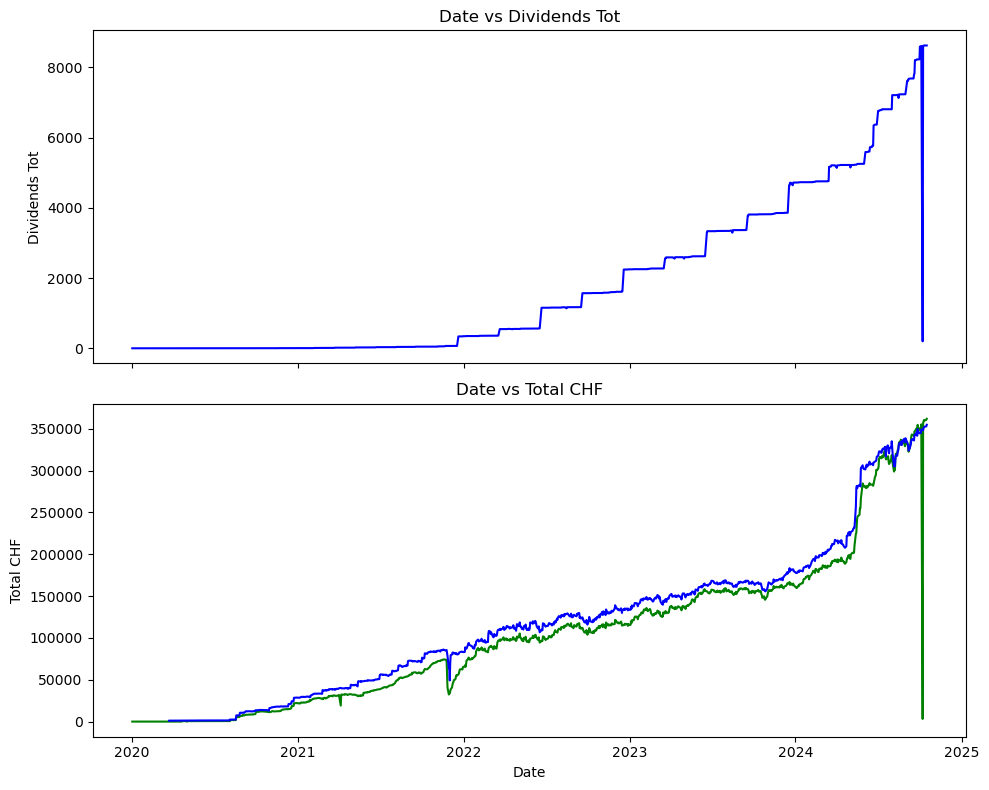

In [ ]:
df_final_sum = df_final.groupby(["Date"], as_index=False)[['Dividends_tot',"total_chf"]].sum()  # ,'category_name'
df_final_sum = pd.merge(df_final_sum, df_snp[["Date", "stock_chf_tot"]], on = ["Date"], how = 'left')
import holidays
us_holidays = holidays.US(years=df_final['Date'].dt.year.unique())
df_final_sum = df_final_sum[~df_final_sum['Date'].isin(us_holidays)]
df_final_sum = df_final_sum[df_final_sum["Date"] != df_final_sum["Date"].max()].copy()

import matplotlib.pyplot as plt
# Ensure 'Date' column is in datetime format if not already
df_final_sum['Date'] = pd.to_datetime(df_final_sum['Date'])
# Create a figure and two subplots (1 row, 2 columns)
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(df_final_sum['Date'], df_final_sum['Dividends_tot'], color='b')
axs[0].set_title('Date vs Dividends Tot')
axs[0].set_ylabel('Dividends Tot')

axs[1].plot(df_final_sum['Date'], df_final_sum['total_chf'], color='g')
axs[1].plot(df_final_sum['Date'], df_final_sum['stock_chf_tot'], color='b')
axs[1].set_title('Date vs Total CHF')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Total CHF')

plt.tight_layout()
plt.show()
df_final_sum.to_csv(r'N:\Trading\Collab\MQA\MEMBER\01_MEMBERS\Gaspard\todelete.csv')
